# Work FLow
- `Packages and Libraries`
-  `Load raw audio data` from files in .WAV format that can be processed
-  `EDA`
-  `Spectral Representations` Convert the audio signal into a frequency domain representation, such as a spectrogram or mel spectrogram.
-  `Conversion to TensorFlow` Convert the preprocessed data into a format suitable for the deep learning framework.
-  `Data Splitting` Split the dataset into training, validation, and testing sets.
-  `Model Building` Build your machine learning model using the preprocessed data.
-  `Converting to TFLite model`

# Packages and Libraries

In [12]:
import os
import pathlib
import wave
import shutil

import librosa

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import soundfile as sf

import IPython.display as display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Loading Raw Audio Data File Paths

The dataset's audio clips are of 6 classes and stored in six folders corresponding to each speech command: 
- `ddyo`
- `kkono`
- `mu maaso`
- `emabega`
- `yimirira`
- `gaali`

In [25]:
TRAIN_DATASET_PATH = 'Dataset/Train'
TEST_DATASET_PATH = 'Dataset/Test'

PROCESS_TRAIN_DATASET_PATH = 'Dataset/Process_train'
PROCESS_TEST_DATASET_PATH = 'Dataset/Process_test'


train_data_dir = pathlib.Path(TRAIN_DATASET_PATH)
test_data_dir = pathlib.Path(TEST_DATASET_PATH)

process_train_data_dir = pathlib.Path(PROCESS_TRAIN_DATASET_PATH)
process_test_data_dir = pathlib.Path(PROCESS_TEST_DATASET_PATH)

# Functions

## 1. Duration(2s), and channel(mono) check function

In [26]:
def move_audio_files(data_dir, process_folder):
    if not os.path.exists(process_folder):
        os.makedirs(process_folder)

    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            for audio_file in os.listdir(subfolder_path):
                audio_path = os.path.join(subfolder_path, audio_file)
                try:
                    # Get audio length and number of channels
                    with wave.open(audio_path, 'r') as wav_file:
                        audio_length = wav_file.getnframes() / wav_file.getframerate()
                        num_channels = wav_file.getnchannels()

                    if audio_length > 2.0 or num_channels != 1:
                        # Move the audio file to the process folder
                        shutil.move(audio_path, os.path.join(process_folder, audio_file))
                except Exception as e:
                    print(f"Error processing {audio_path}: {e}")



move_audio_files(train_data_dir, process_train_data_dir)

move_audio_files(test_data_dir, process_test_data_dir)


## 2. Count audio files function

In [20]:
def count_audio_files_in_subfolders(data_dir):
    counts = {}
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if os.path.isdir(subfolder_path):
            audio_files_count = len([f for f in os.listdir(subfolder_path) if f.endswith('.wav')])
            counts[subfolder] = audio_files_count
    return counts

## 3. Function to determine the size of the model

In [34]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

# Exploratory Data Analysis (EDA) 

## Labels (Train and Test Directories)

In [27]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
print(f'Train commands labels:\n {commands}')

commands = np.array(tf.io.gfile.listdir(str(test_data_dir)))
print()
print(f'Test commands labels:\n {commands}')

Train commands labels:
 ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']

Test commands labels:
 ['emabega' 'ddyo' 'gaali' 'kkono' 'mu masso' 'yimirira']


## Number of audio files

### 1. Training dataset

In [29]:
counts = count_audio_files_in_subfolders(train_data_dir)
print(f'Train \n{counts}')
print()

Train 
{'emabega': 1539, 'ddyo': 1564, 'gaali': 1437, 'kkono': 1595, 'mu masso': 1565, 'yimirira': 1504}



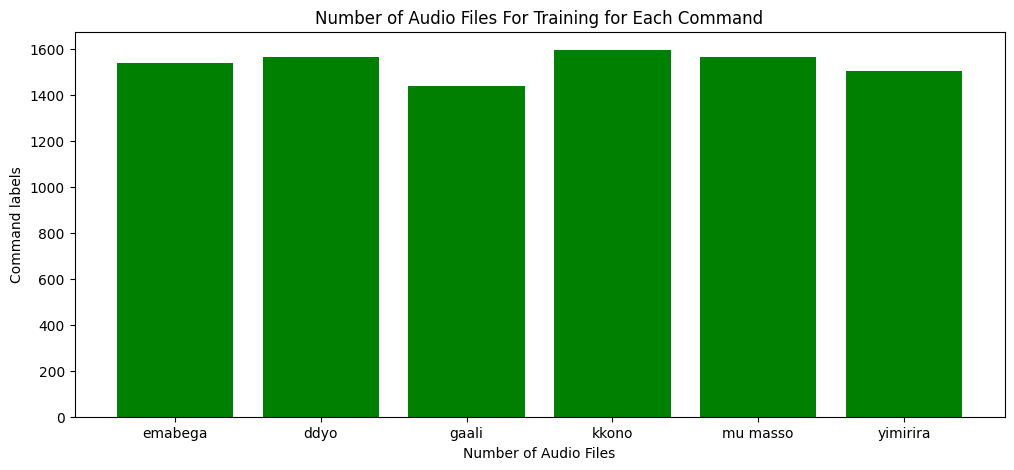

In [31]:
plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), color='green')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

### 2. Test dataset

In [32]:
counts = count_audio_files_in_subfolders(test_data_dir)
print(f'Test \n{counts}')
print()

Test 
{'emabega': 302, 'ddyo': 302, 'gaali': 307, 'kkono': 310, 'mu masso': 306, 'yimirira': 305}



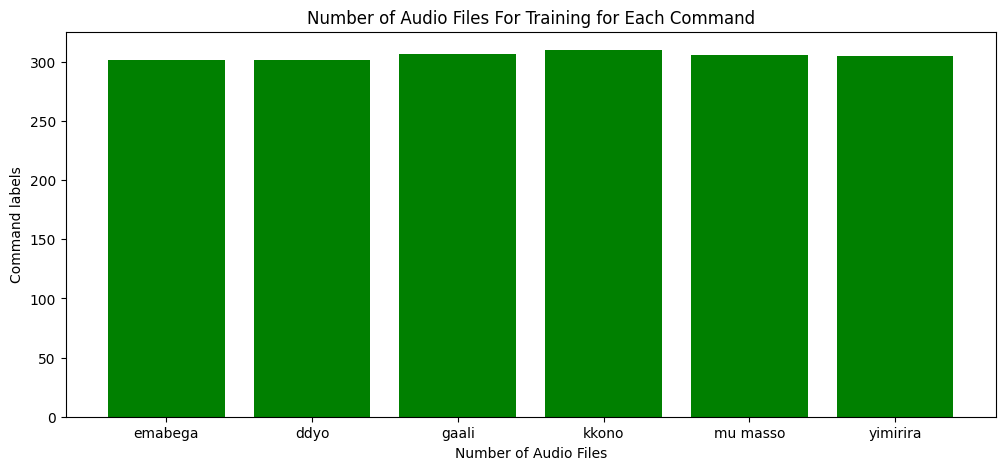

In [33]:
plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), color='green')
plt.xlabel('Number of Audio Files')
plt.ylabel('Command labels')
plt.title('Number of Audio Files For Training for Each Command')
plt.show()

## Audio Properties and Parameters
- using one audio file

In [69]:
SAMPLE_RATE = 16000

In [70]:
example_audio_path = os.path.join(TRAIN_DATASET_PATH, 'emabega', 'emabega #225.wav')
audio_signal, sample_rate = librosa.load(example_audio_path, sr=SAMPLE_RATE)
audio = wave.open(example_audio_path, 'rb')

In [71]:
num_channels = audio.getnchannels()
sample_width = audio.getsampwidth()
frame_rate = audio.getframerate()
num_frames = audio.getnframes()
duration = num_frames / float(frame_rate)

In [72]:
print("Number of channels:    ", num_channels)
print("Sample width (bytes):  ", sample_width)
print("Frame rate (Hz):       ", frame_rate)
print("Number of frames:      ", num_frames)
print("Duration (s):          ", duration)
print("Parameters:            ", audio.getparams())

Number of channels:     1
Sample width (bytes):   2
Frame rate (Hz):        16000
Number of frames:       22720
Duration (s):           1.42
Parameters:             _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=22720, comptype='NONE', compname='not compressed')


In [73]:
audio.close()

### Visualize the audio waveform

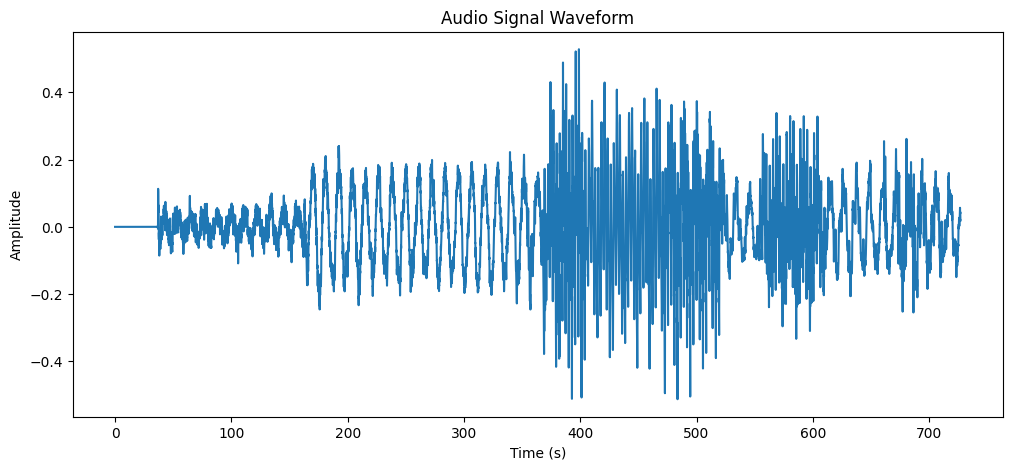

In [74]:
time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)

plt.figure(figsize=(12, 5))
plt.plot(time, audio_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Signal Waveform')
plt.show()

### Amplitude Distribution

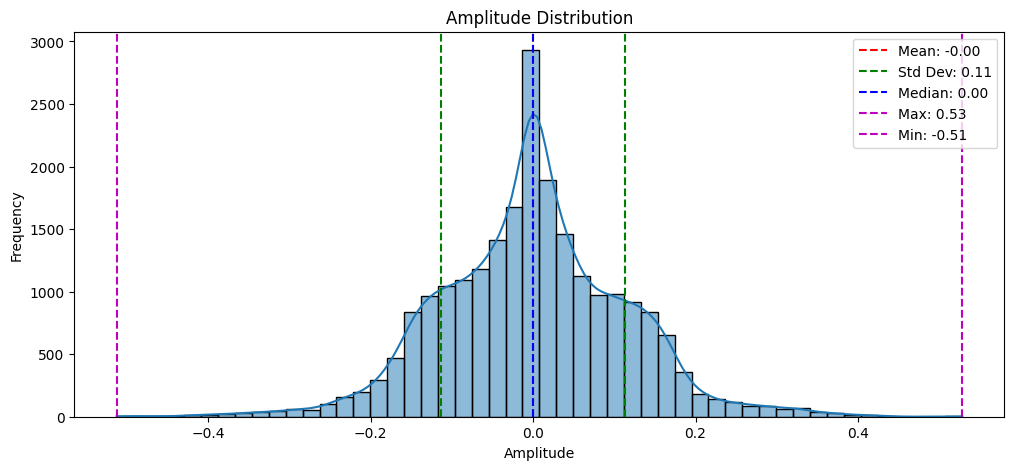

In [75]:
# Calculate statistical summary information
mean_amplitude = np.mean(audio_signal)
std_deviation = np.std(audio_signal)
max_amplitude = np.max(audio_signal)
min_amplitude = np.min(audio_signal)
median_amplitude = np.median(audio_signal)

# Plot the histogram with additional features
plt.figure(figsize=(12, 5))

# Plot the histogram
sns.histplot(audio_signal, bins=50, kde=True)

# Add vertical lines for statistical summary information
plt.axvline(mean_amplitude, color='r', linestyle='--', label=f'Mean: {mean_amplitude:.2f}')
plt.axvline(mean_amplitude + std_deviation, color='g', linestyle='--', label=f'Std Dev: {std_deviation:.2f}')
plt.axvline(mean_amplitude - std_deviation, color='g', linestyle='--')
plt.axvline(median_amplitude, color='b', linestyle='--', label=f'Median: {median_amplitude:.2f}')
plt.axvline(max_amplitude, color='m', linestyle='--', label=f'Max: {max_amplitude:.2f}')
plt.axvline(min_amplitude, color='m', linestyle='--', label=f'Min: {min_amplitude:.2f}')

# Set plot title and labels
plt.title('Amplitude Distribution')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Play audio file

In [76]:
display.Audio(example_audio_path)

# Train and validation Datasets

In [77]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    validation_split=0.25,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8206 files belonging to 6 classes.
Using 6155 files for training.
Using 2051 files for validation.

label names: ['ddyo' 'emabega' 'gaali' 'kkono' 'mu masso' 'yimirira']


In [78]:
# The shape of the audio clip
# - (batch, samples, channels)

element_spec = train_ds.element_spec
print(element_spec)

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [79]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [80]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [81]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Test dataset

In [82]:
test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=test_data_dir,
    batch_size=64,
    validation_split=None,  # No need to split the test dataset
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    shuffle=False  # Disable shuffling for the test dataset
)

test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

# Shard the test dataset
test_ds = test_ds.shard(num_shards=2, index=0)

Found 1659 files belonging to 6 classes.


In [83]:
for example_audio, example_labels in test_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


# Plot a few audio waveforms:

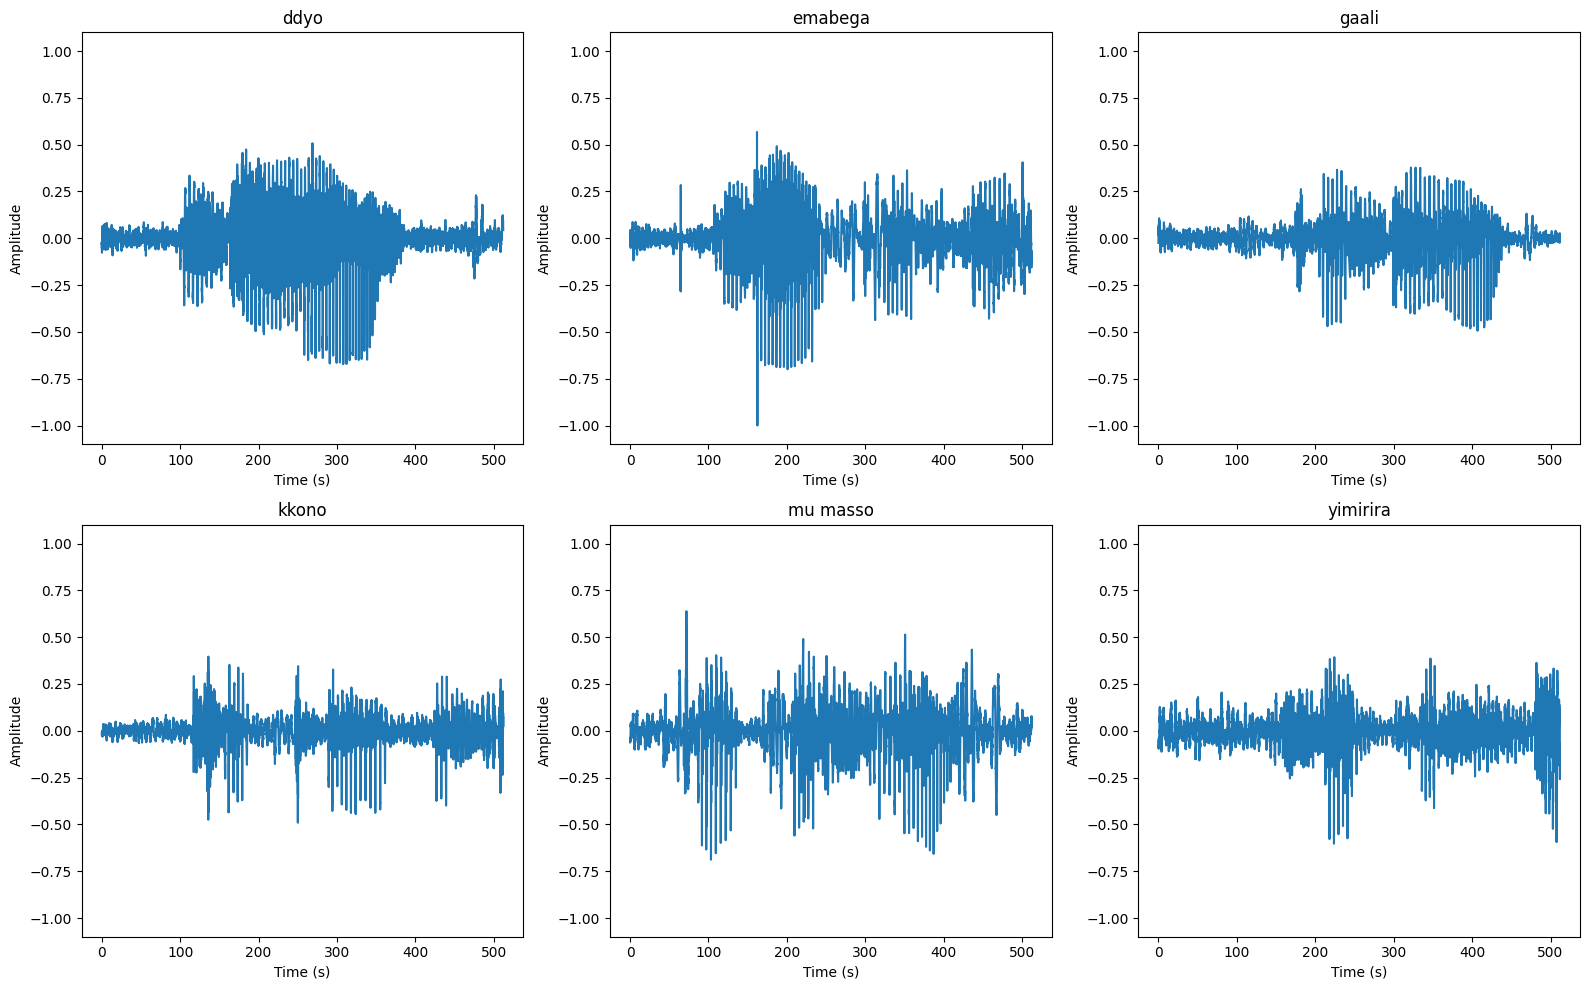

In [84]:
label_names_slice = label_names[:6]  # Select the first six labels
plt.figure(figsize=(16, 10))
rows = 2
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    time = librosa.times_like(audio_signal, sr=SAMPLE_RATE)
    plt.plot(time, audio_signal)
    plt.title(label_names_slice[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()


# Feature Extraction

In [85]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

## Tensorized waveform
The shapes of a tensorized waveform and the corresponding spectrogram, and play the original audio.

In [86]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: ddyo
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


### Visualization of spectrogram

In [87]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
      
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Plot of waveform and spectrogram.

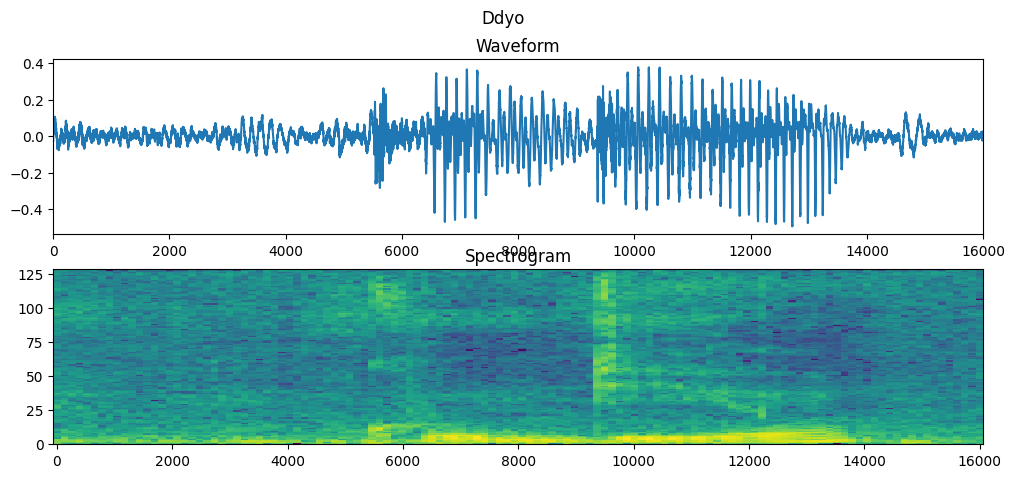

In [88]:
fig, axes = plt.subplots(2, figsize=(12, 5))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Create spectrogram datasets

In [89]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [90]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

## Visualization of the spectrograms

In [91]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

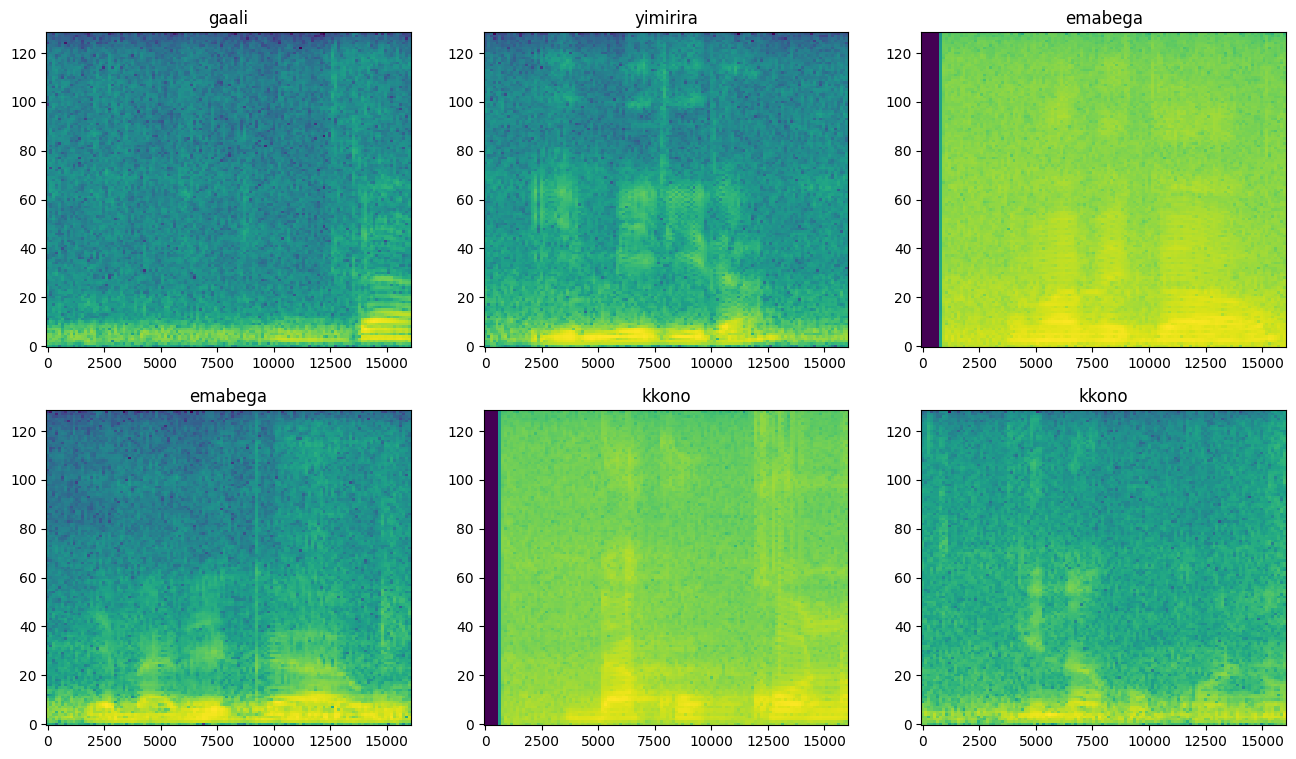

In [92]:
rows = 2
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

 `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [93]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [94]:
train_spectrogram_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Building Models

## Model 1

1. **Input Layer**: Defines the input shape for the model based on the shape of the spectrogram images.
2. **Convolutional Layers**:
   - 2.1. First Conv2D Layer: Applies 32 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 2.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
3. **Convolutional Layers**:
   - 3.1. Second Conv2D Layer: Applies 64 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 3.2. MaxPooling2D Layer: Performs max pooling to downsample the feature maps.
4. **Convolutional Layers**:
   - 4.1. Third Conv2D Layer: Applies 128 filters with a 3x3 kernel size, ReLU activation function, and dilation rate of (2, 2).
   - 4.2. GlobalAveragePooling2D Layer: Performs global average pooling to reduce spatial dimensions.
5. **Dense Layers**:
   - 5.1. Dense Layer: Applies 128 neurons with ReLU activation function.
   - 5.2. Dropout Layer: Applies dropout regularization with a dropout rate of 0.5.
   - 5.3. Dense Layer: Outputs logits for each class, with the number of units equal to the number of labels.

### Input shape 

In [100]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Normalization layer

In [96]:
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

### Model Arch

In [109]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 29, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 25, 128)       73856     
                                                                 
 global_average_pooling2d_3  (None, 128)              

### Model Arch

In [101]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 58, 64)        18496     
                                                                 
 global_average_pooling2d_2  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)               

### Compile the model

In [110]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [111]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
97/97 [==============================] - 84s 847ms/step - loss: 1.5593 - accuracy: 0.3400 - val_loss: 1.2478 - val_accuracy: 0.5342
Epoch 2/15
97/97 [==============================] - 83s 856ms/step - loss: 1.0886 - accuracy: 0.6081 - val_loss: 0.9383 - val_accuracy: 0.6875
Epoch 3/15
97/97 [==============================] - 84s 865ms/step - loss: 0.8861 - accuracy: 0.6993 - val_loss: 0.7835 - val_accuracy: 0.7461
Epoch 4/15
97/97 [==============================] - 85s 873ms/step - loss: 0.7889 - accuracy: 0.7379 - val_loss: 0.7341 - val_accuracy: 0.7432
Epoch 5/15
97/97 [==============================] - 89s 914ms/step - loss: 0.7093 - accuracy: 0.7665 - val_loss: 0.6520 - val_accuracy: 0.7812
Epoch 6/15
97/97 [==============================] - 90s 928ms/step - loss: 0.6478 - accuracy: 0.7873 - val_loss: 0.6073 - val_accuracy: 0.7891
Epoch 7/15
97/97 [==============================] - 90s 928ms/step - loss: 0.6166 - accuracy: 0.8005 - val_loss: 0.5655 - val_accuracy: 0.8096

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

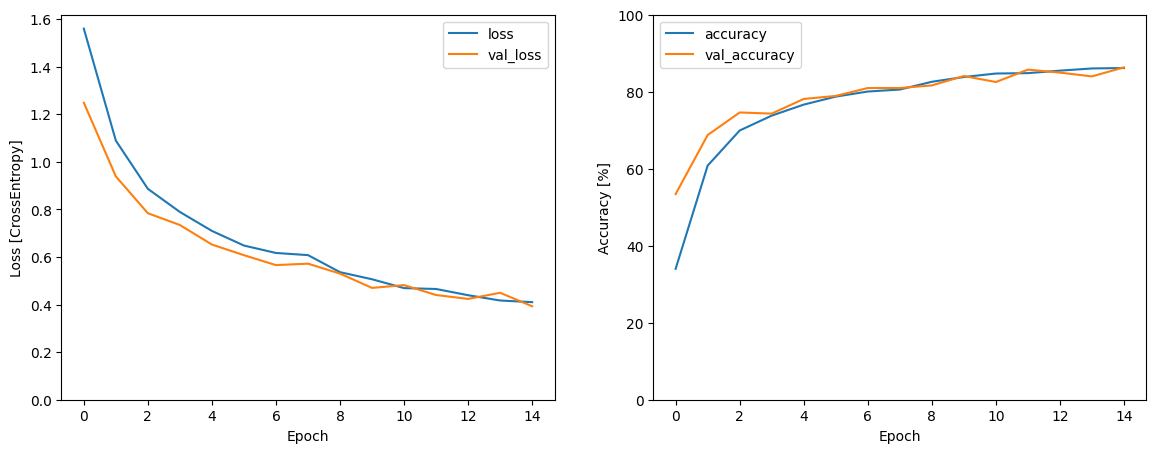

In [112]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [114]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 5s 362ms/step - loss: 0.5095 - accuracy: 0.8233


{'loss': 0.5095402002334595, 'accuracy': 0.823317289352417}

In [115]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

13/13 [==============================] - 5s 355ms/step


In [116]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.831542470716901
Recall: 0.8233173076923077
F1-score: 0.8206353529302254


### Display the confusion matix

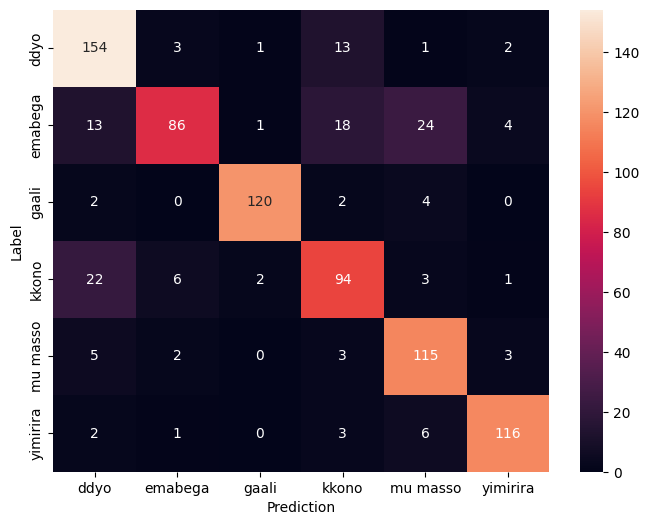

In [117]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

## Tensorflow model

In [108]:
KERAS_MODEL_NAME = "my_model_2.keras"
model2.save(KERAS_MODEL_NAME)

In [109]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

File size: 310.559 Kilobytes


## TFLite Model for model

In [110]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5yom53rf/assets


INFO:tensorflow:Assets written to: /tmp/tmp5yom53rf/assets
2024-02-27 09:10:25.927679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:10:25.927720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:10:25.928067: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5yom53rf
2024-02-27 09:10:25.929077: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:10:25.929099: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5yom53rf
2024-02-27 09:10:25.931321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-27 09:10:25.932243: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:10:25.978683: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

In [111]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model2.tflite')
interpreter.allocate_tensors()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [112]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [113]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [114]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [115]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [116]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 15%


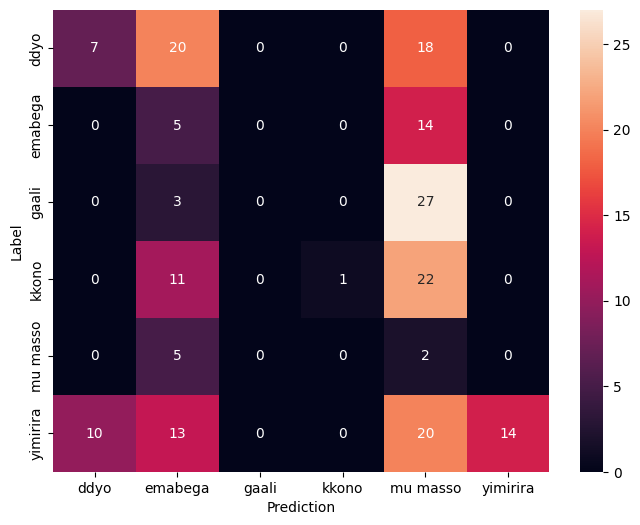

In [117]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [118]:
convert_bytes(get_file_size("model2.tflite"), "KB")

File size: 96.195 Kilobytes


## Quntized model

In [119]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp48tf9hyg/assets


INFO:tensorflow:Assets written to: /tmp/tmp48tf9hyg/assets
2024-02-27 09:10:29.928236: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:10:29.928269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:10:29.928472: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp48tf9hyg
2024-02-27 09:10:29.929838: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:10:29.929851: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp48tf9hyg
2024-02-27 09:10:29.933558: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:10:29.985802: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp48tf9hyg
2024-02-27 09:10:30.003326: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpghvk7m8b/assets


INFO:tensorflow:Assets written to: /tmp/tmpghvk7m8b/assets
2024-02-27 09:10:33.218301: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:10:33.218334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:10:33.218546: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpghvk7m8b
2024-02-27 09:10:33.220067: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:10:33.220081: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpghvk7m8b
2024-02-27 09:10:33.223793: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:10:33.270848: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpghvk7m8b
2024-02-27 09:10:33.287354: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [120]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 31.047 Kilobytes


In [121]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.15104166666666666


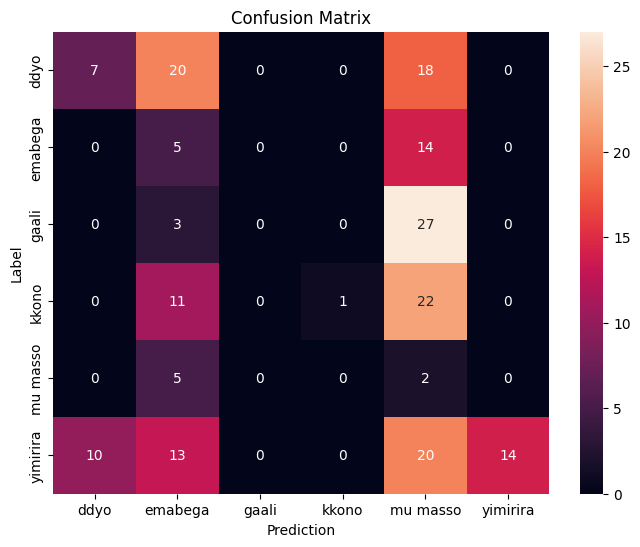

In [122]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [123]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 15%


## Model 3

1. **Input Layer:** Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer:** Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer:** Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers:** Two Conv2D layers with ReLU activation functions, followed by max pooling.
5. **Dropout Layer:** Applies dropout regularization to prevent overfitting.
6. **Flatten Layer:** Flattens the output of the previous layer into a 1D vector.
7. **Dense Layers:** Two Dense layers with ReLU activation functions, followed by the output layer with logits for each class.

### Input shape 

In [124]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Model Arch

In [125]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)       

### Compile the model

In [126]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [127]:
EPOCHS = 15
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15
43/43 [==============================] - 5s 87ms/step - loss: 0.8407 - accuracy: 0.6815 - val_loss: 0.3166 - val_accuracy: 0.9040
Epoch 2/15
43/43 [==============================] - 4s 84ms/step - loss: 0.3061 - accuracy: 0.8907 - val_loss: 0.1933 - val_accuracy: 0.9420
Epoch 3/15
43/43 [==============================] - 4s 86ms/step - loss: 0.1976 - accuracy: 0.9337 - val_loss: 0.1514 - val_accuracy: 0.9442
Epoch 4/15
43/43 [==============================] - 4s 91ms/step - loss: 0.1478 - accuracy: 0.9456 - val_loss: 0.1157 - val_accuracy: 0.9598
Epoch 5/15
43/43 [==============================] - 4s 91ms/step - loss: 0.1252 - accuracy: 0.9578 - val_loss: 0.0969 - val_accuracy: 0.9576
Epoch 6/15
43/43 [==============================] - 4s 98ms/step - loss: 0.0993 - accuracy: 0.9670 - val_loss: 0.0711 - val_accuracy: 0.9710
Epoch 7/15
43/43 [==============================] - 4s 98ms/step - loss: 0.0807 - accuracy: 0.9722 - val_loss: 0.0802 - val_accuracy: 0.9665
Epoch 8/15
43

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

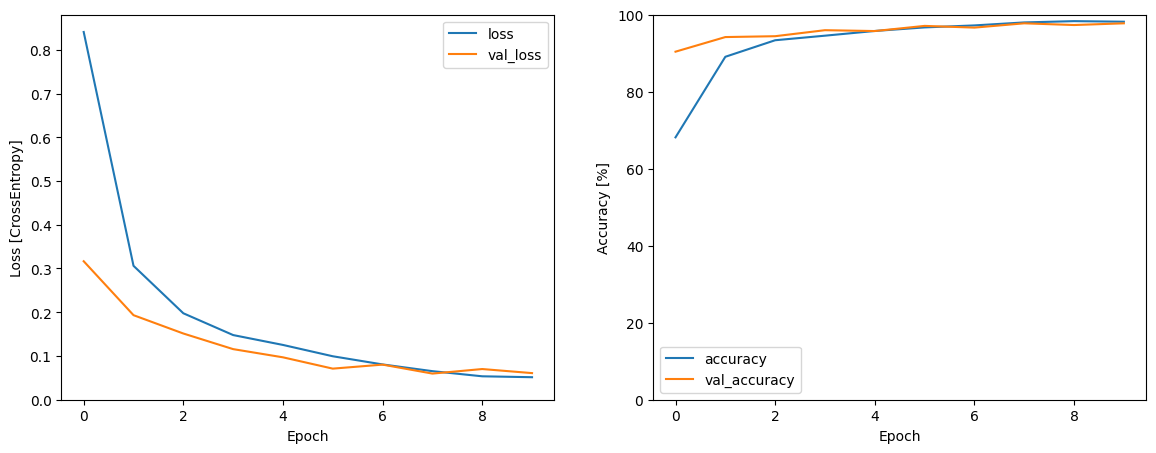

In [128]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [129]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

192/192 [==============================] - 1s 3ms/step - loss: 3.5394 - accuracy: 0.2135


{'loss': 3.5394489765167236, 'accuracy': 0.2135416716337204}

In [130]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

192/192 [==============================] - 1s 2ms/step


In [131]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5502757256184676
Recall: 0.21354166666666666
F1-score: 0.27816653833185584


### Display the confusion matix

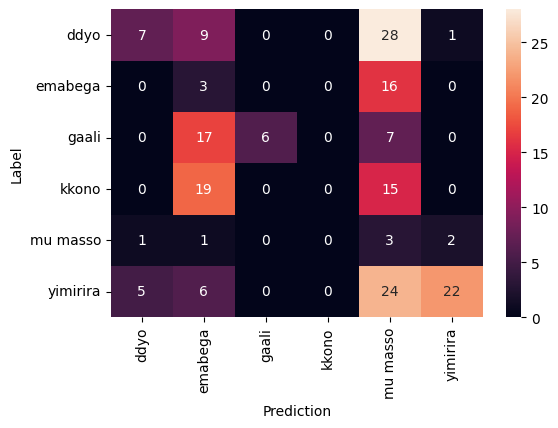

In [132]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [133]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [134]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [135]:
KERAS_MODEL_NAME = "my_model_3.keras"
model.save(KERAS_MODEL_NAME)

In [136]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 0.447 Megabytes


## TFLite Model for model

In [137]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model3.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5da2k8cb/assets


INFO:tensorflow:Assets written to: /tmp/tmp5da2k8cb/assets
2024-02-27 09:11:22.910785: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:11:22.910823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:11:22.911070: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5da2k8cb
2024-02-27 09:11:22.912742: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:11:22.912759: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5da2k8cb
2024-02-27 09:11:22.917527: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:11:22.983950: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5da2k8cb
2024-02-27 09:11:23.000599: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [138]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model3.tflite')
interpreter.allocate_tensors()


In [139]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [140]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [141]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [142]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [143]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 21%


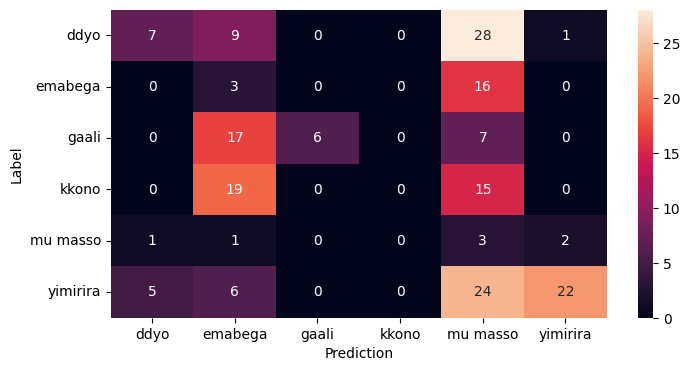

In [144]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [145]:
convert_bytes(get_file_size("model3.tflite"), "MB")

File size: 6.204 Megabytes


## Quntized model

In [146]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model3.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpco_0baf2/assets


INFO:tensorflow:Assets written to: /tmp/tmpco_0baf2/assets
2024-02-27 09:11:27.337545: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:11:27.337580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:11:27.337803: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpco_0baf2
2024-02-27 09:11:27.339890: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:11:27.339907: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpco_0baf2
2024-02-27 09:11:27.345001: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:11:27.417730: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpco_0baf2
2024-02-27 09:11:27.437827: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzznoxsib/assets


INFO:tensorflow:Assets written to: /tmp/tmpzznoxsib/assets
2024-02-27 09:11:30.746850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:11:30.746884: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:11:30.747110: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpzznoxsib
2024-02-27 09:11:30.748771: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:11:30.748784: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpzznoxsib
2024-02-27 09:11:30.752735: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:11:30.809568: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpzznoxsib
2024-02-27 09:11:30.824565: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [147]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 1595.375 Kilobytes


In [148]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.21354166666666666


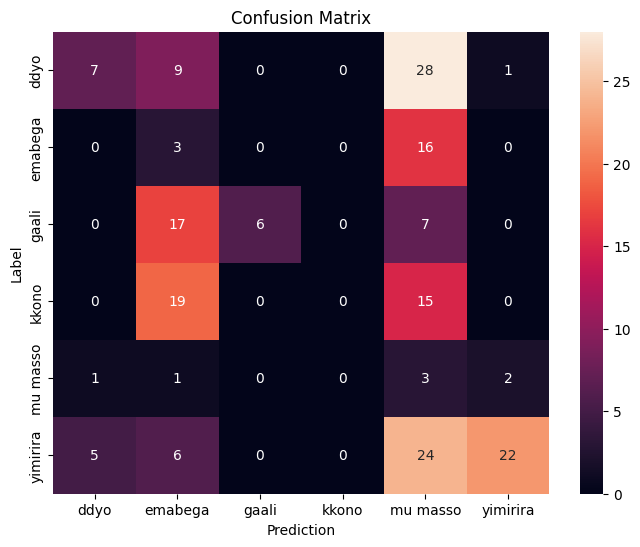

In [149]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [150]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 21%


### Compile the model

In [151]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [152]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
43/43 [==============================] - 36s 811ms/step - loss: 1.5294 - accuracy: 0.3341 - val_loss: 1.1212 - val_accuracy: 0.5647
Epoch 2/20
43/43 [==============================] - 34s 812ms/step - loss: 0.9661 - accuracy: 0.6056 - val_loss: 0.6713 - val_accuracy: 0.7902
Epoch 3/20
43/43 [==============================] - 35s 806ms/step - loss: 0.5929 - accuracy: 0.7870 - val_loss: 0.4198 - val_accuracy: 0.8750
Epoch 4/20
43/43 [==============================] - 34s 785ms/step - loss: 0.4380 - accuracy: 0.8444 - val_loss: 0.2948 - val_accuracy: 0.8951
Epoch 5/20
43/43 [==============================] - 35s 821ms/step - loss: 0.3688 - accuracy: 0.8715 - val_loss: 0.2559 - val_accuracy: 0.9129
Epoch 6/20
43/43 [==============================] - 35s 807ms/step - loss: 0.2845 - accuracy: 0.9033 - val_loss: 0.2030 - val_accuracy: 0.9308
Epoch 7/20
43/43 [==============================] - 36s 829ms/step - loss: 0.2412 - accuracy: 0.9219 - val_loss: 0.1928 - val_accuracy: 0.9174

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

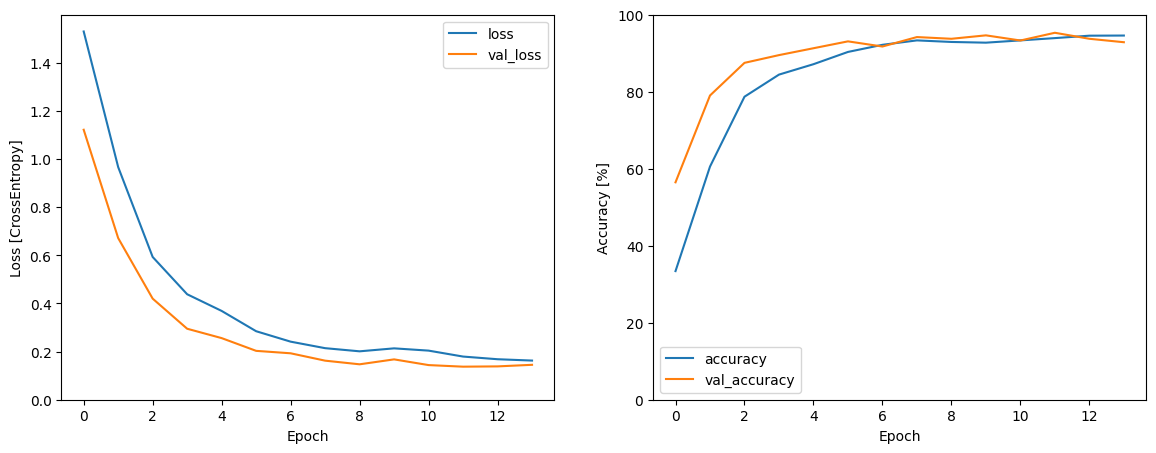

In [153]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [154]:
model.evaluate(test_spectrogram_ds, return_dict=True)

192/192 [==============================] - 1s 6ms/step - loss: 3.1032 - accuracy: 0.2708


{'loss': 3.103163719177246, 'accuracy': 0.2708333432674408}

### Display a confusion matrix

In [155]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

192/192 [==============================] - 1s 5ms/step


In [156]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.7719455024142525
Recall: 0.2708333333333333
F1-score: 0.30599631897771873


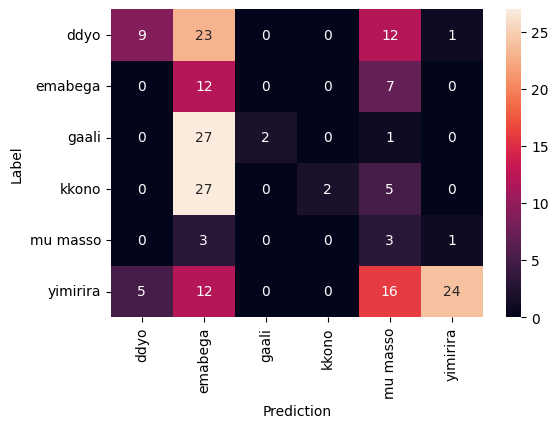

In [157]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [158]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [159]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [160]:
KERAS_MODEL_NAME = "my_model_1.keras"
model.save(KERAS_MODEL_NAME)

In [161]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.301 Megabytes


## TFLite Model for model

In [162]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmxqo88p4/assets


INFO:tensorflow:Assets written to: /tmp/tmpmxqo88p4/assets
2024-02-27 09:19:45.926741: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:19:45.926772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:19:45.926974: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmxqo88p4
2024-02-27 09:19:45.928690: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:19:45.928703: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpmxqo88p4
2024-02-27 09:19:45.932973: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:19:45.984659: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpmxqo88p4
2024-02-27 09:19:46.000070: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [163]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()


In [164]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [165]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [166]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [167]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [168]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 27%


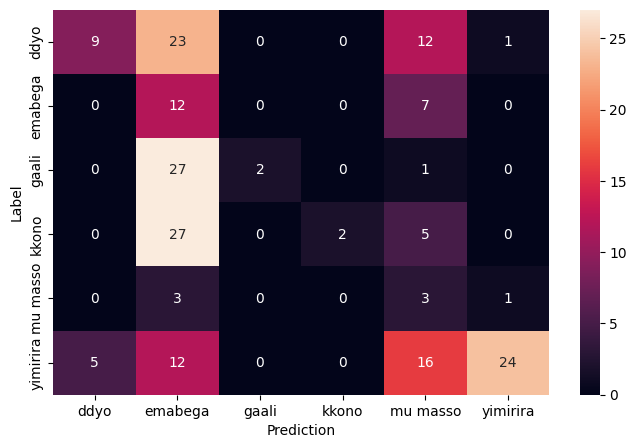

In [169]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [170]:
convert_bytes(get_file_size("model.tflite"), "KB")

File size: 436.156 Kilobytes


## Quntized model

In [171]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp4qhjyrkd/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qhjyrkd/assets
2024-02-27 09:19:50.365382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:19:50.365417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:19:50.365615: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4qhjyrkd
2024-02-27 09:19:50.367188: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:19:50.367201: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4qhjyrkd
2024-02-27 09:19:50.371228: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:19:50.422473: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4qhjyrkd
2024-02-27 09:19:50.439382: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpefgcban3/assets


INFO:tensorflow:Assets written to: /tmp/tmpefgcban3/assets
2024-02-27 09:19:53.495514: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:19:53.495553: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:19:53.495759: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpefgcban3
2024-02-27 09:19:53.497327: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:19:53.497340: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpefgcban3
2024-02-27 09:19:53.501207: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:19:53.553879: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpefgcban3
2024-02-27 09:19:53.571266: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [172]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 120.531 Kilobytes


In [173]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.2708333333333333


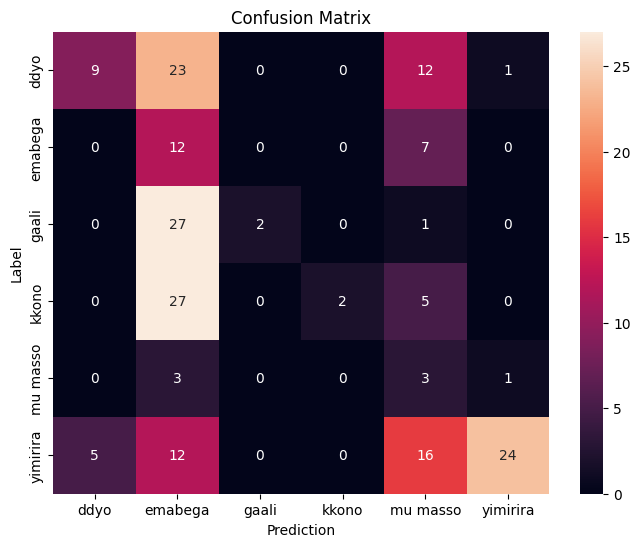

In [174]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [175]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 27%


## Model 2

1. Input layer: Accepts input data of shape `input_shape`.
2. Conv2D layer with 32 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
3. MaxPooling2D layer.
4. Conv2D layer with 64 filters, kernel size 3x3, and ReLU activation. Dilated convolution with dilation rate (2, 2).
5. GlobalAveragePooling2D layer: Reduces spatial dimensions to 1x1.
6. Dense layer with 64 neurons and ReLU activation.
7. Dropout layer with dropout rate of 0.5.
8. Dense output layer with `num_labels` neurons (output classes).


### Input shape 

In [176]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Model Arch

In [177]:
model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu', dilation_rate=(2, 2)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu', dilation_rate=(2, 2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 120, 125, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 60, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 58, 64)        18496     
                                                                 
 global_average_pooling2d_3  (None, 64)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

### Compile the model

In [178]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [179]:
EPOCHS = 20
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
43/43 [==============================] - 29s 652ms/step - loss: 1.7483 - accuracy: 0.1970 - val_loss: 1.6407 - val_accuracy: 0.2567
Epoch 2/20
43/43 [==============================] - 26s 606ms/step - loss: 1.5527 - accuracy: 0.3570 - val_loss: 1.3744 - val_accuracy: 0.4688
Epoch 3/20
43/43 [==============================] - 27s 630ms/step - loss: 1.2900 - accuracy: 0.4659 - val_loss: 1.1415 - val_accuracy: 0.5938
Epoch 4/20
43/43 [==============================] - 28s 637ms/step - loss: 1.1086 - accuracy: 0.5730 - val_loss: 0.9578 - val_accuracy: 0.6496
Epoch 5/20
43/43 [==============================] - 28s 642ms/step - loss: 0.9354 - accuracy: 0.6496 - val_loss: 0.8083 - val_accuracy: 0.7009
Epoch 6/20
43/43 [==============================] - 27s 623ms/step - loss: 0.8132 - accuracy: 0.6937 - val_loss: 0.6980 - val_accuracy: 0.7344
Epoch 7/20
43/43 [==============================] - 28s 649ms/step - loss: 0.7273 - accuracy: 0.7219 - val_loss: 0.6251 - val_accuracy: 0.7634

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

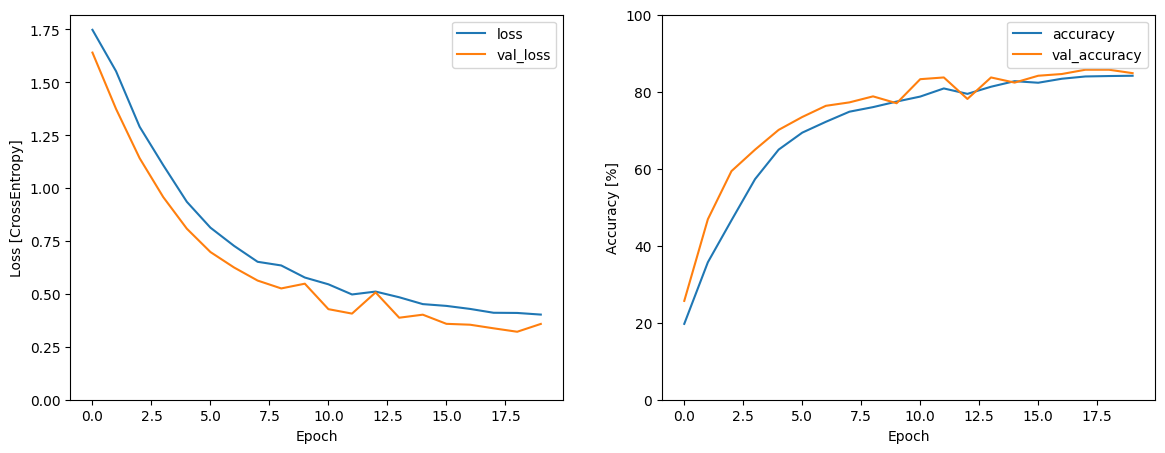

In [180]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [181]:
model2.evaluate(test_spectrogram_ds, return_dict=True)

192/192 [==============================] - 1s 5ms/step - loss: 2.2796 - accuracy: 0.2448


{'loss': 2.279606580734253, 'accuracy': 0.2447916716337204}

In [182]:
y_pred = model2.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

192/192 [==============================] - 1s 4ms/step


In [183]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5483563630999213
Recall: 0.24479166666666666
F1-score: 0.23286182004306535


### Display the confusion matix

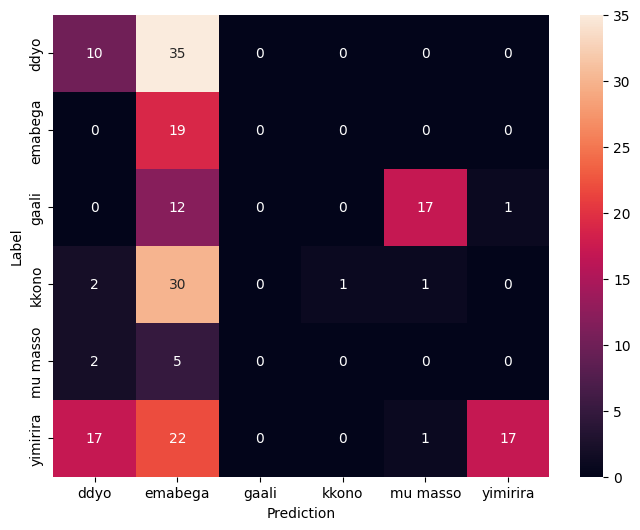

In [184]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [185]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [186]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [187]:
KERAS_MODEL_NAME = "my_model_2.keras"
model2.save(KERAS_MODEL_NAME)

In [188]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "KB")

File size: 310.561 Kilobytes


## TFLite Model for model

In [189]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmph8y3gkuo/assets


INFO:tensorflow:Assets written to: /tmp/tmph8y3gkuo/assets
2024-02-27 09:29:11.995960: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:29:11.995992: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:29:11.996197: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmph8y3gkuo
2024-02-27 09:29:11.997679: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:29:11.997694: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmph8y3gkuo
2024-02-27 09:29:12.001439: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:29:12.049020: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmph8y3gkuo
2024-02-27 09:29:12.062088: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [190]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model2.tflite')
interpreter.allocate_tensors()


In [191]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [192]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [193]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [194]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [195]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 24%


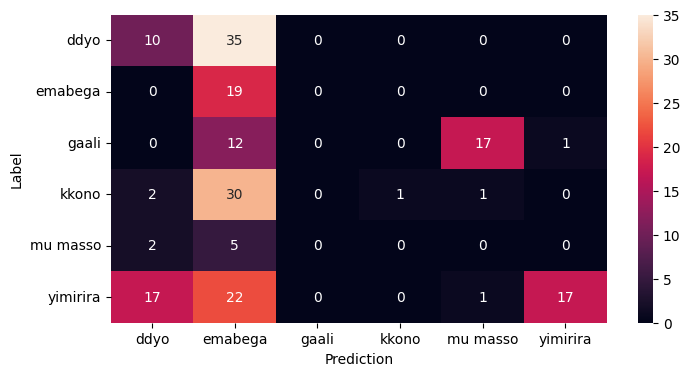

In [196]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [197]:
convert_bytes(get_file_size("model2.tflite"), "KB")

File size: 96.215 Kilobytes


## Quntized model

In [198]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpnzj3t5oy/assets


INFO:tensorflow:Assets written to: /tmp/tmpnzj3t5oy/assets
2024-02-27 09:29:15.651551: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:29:15.651585: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:29:15.651801: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnzj3t5oy
2024-02-27 09:29:15.653306: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:29:15.653321: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpnzj3t5oy
2024-02-27 09:29:15.657182: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:29:15.706855: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpnzj3t5oy
2024-02-27 09:29:15.722625: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt448b9j_/assets


INFO:tensorflow:Assets written to: /tmp/tmpt448b9j_/assets
2024-02-27 09:29:18.392526: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:29:18.392563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:29:18.392776: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpt448b9j_
2024-02-27 09:29:18.394125: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:29:18.394139: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpt448b9j_
2024-02-27 09:29:18.397635: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:29:18.442092: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpt448b9j_
2024-02-27 09:29:18.456611: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [199]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 31.07 Kilobytes


In [200]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.24479166666666666


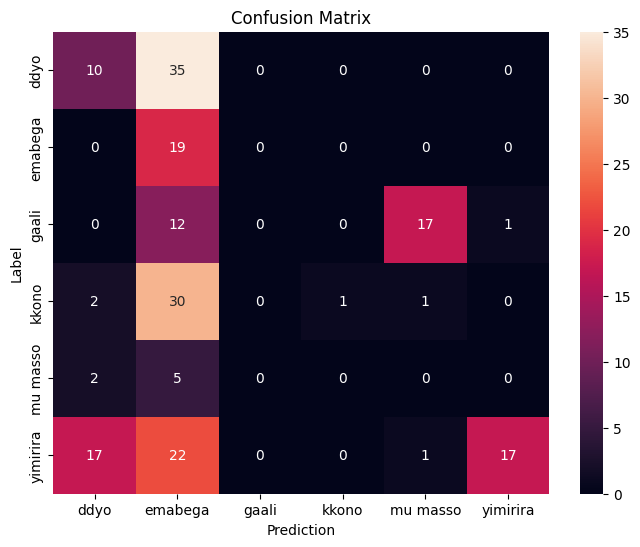

In [201]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [202]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 24%


## Model 3

1. **Input Layer:** Defines the input shape for the model based on the shape of the spectrogram images.
2. **Resizing Layer:** Resizes the input spectrogram images to a fixed size of 32x32 pixels.
3. **Normalization Layer:** Normalizes the input data using statistics computed from the training dataset.
4. **Convolutional Layers:** Two Conv2D layers with ReLU activation functions, followed by max pooling.
5. **Dropout Layer:** Applies dropout regularization to prevent overfitting.
6. **Flatten Layer:** Flattens the output of the previous layer into a 1D vector.
7. **Dense Layers:** Two Dense layers with ReLU activation functions, followed by the output layer with logits for each class.

### Input shape 

In [203]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (124, 129, 1)


### Model Arch

In [204]:
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)       

### Compile the model

In [205]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Train the model

In [206]:
EPOCHS = 20
history = model3.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
43/43 [==============================] - 4s 76ms/step - loss: 0.7923 - accuracy: 0.6967 - val_loss: 0.3336 - val_accuracy: 0.8862
Epoch 2/20
43/43 [==============================] - 3s 78ms/step - loss: 0.3257 - accuracy: 0.8885 - val_loss: 0.1832 - val_accuracy: 0.9397
Epoch 3/20
43/43 [==============================] - 4s 88ms/step - loss: 0.2047 - accuracy: 0.9278 - val_loss: 0.1591 - val_accuracy: 0.9442
Epoch 4/20
43/43 [==============================] - 4s 81ms/step - loss: 0.1644 - accuracy: 0.9519 - val_loss: 0.1198 - val_accuracy: 0.9487
Epoch 5/20
43/43 [==============================] - 4s 82ms/step - loss: 0.1058 - accuracy: 0.9593 - val_loss: 0.0864 - val_accuracy: 0.9621
Epoch 6/20
43/43 [==============================] - 3s 81ms/step - loss: 0.0960 - accuracy: 0.9670 - val_loss: 0.0782 - val_accuracy: 0.9732
Epoch 7/20
43/43 [==============================] - 4s 82ms/step - loss: 0.0751 - accuracy: 0.9763 - val_loss: 0.0654 - val_accuracy: 0.9754
Epoch 8/20
43

### Plot Accuracy and Loss

Text(0, 0.5, 'Accuracy [%]')

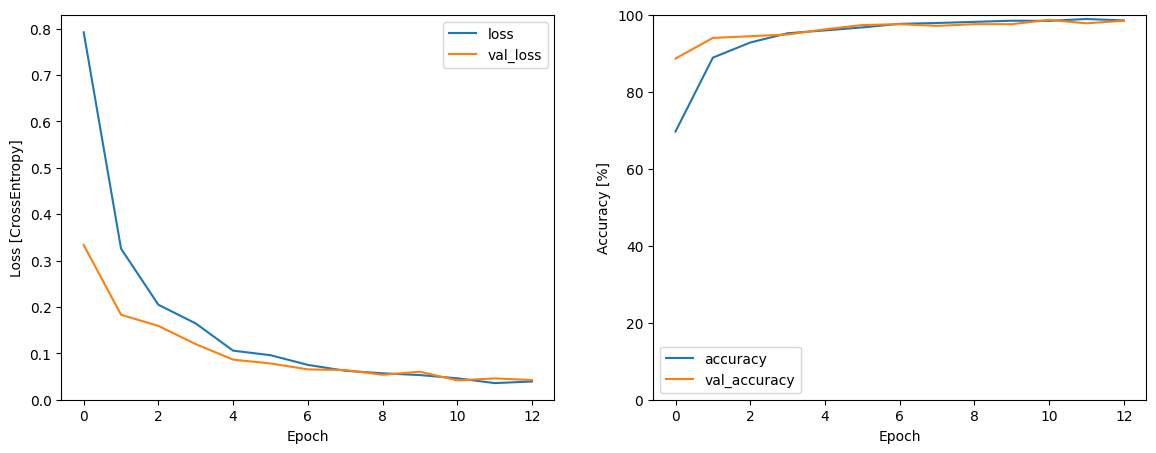

In [207]:
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Evaluate the model performance

Run the model on the test set and check the model's performance:

In [208]:
model3.evaluate(test_spectrogram_ds, return_dict=True)

192/192 [==============================] - 0s 2ms/step - loss: 3.1681 - accuracy: 0.2031


{'loss': 3.1681063175201416, 'accuracy': 0.203125}

In [209]:
y_pred = model3.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

192/192 [==============================] - 0s 2ms/step


In [210]:
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.6107393029675638
Recall: 0.203125
F1-score: 0.24992853942827753


### Display the confusion matix

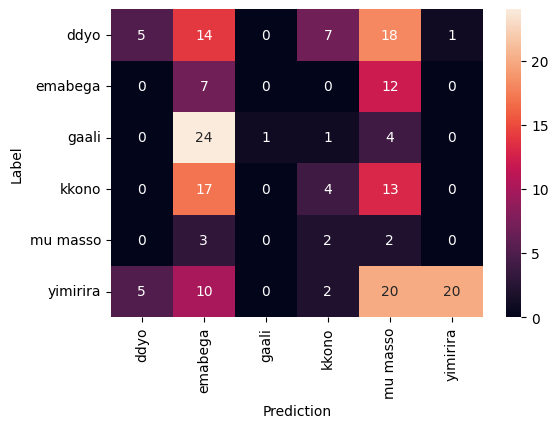

In [211]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Function to determine the size of the model

In [212]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [213]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

## Tensorflow model

In [214]:
KERAS_MODEL_NAME = "my_model_3.keras"
model.save(KERAS_MODEL_NAME)

In [215]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.301 Megabytes


## TFLite Model for model

In [216]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open('model3.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgqywjv12/assets


INFO:tensorflow:Assets written to: /tmp/tmpgqywjv12/assets
2024-02-27 09:30:11.839990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:30:11.840026: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:30:11.840241: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgqywjv12
2024-02-27 09:30:11.842006: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:30:11.842020: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgqywjv12
2024-02-27 09:30:11.846274: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:30:11.904964: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpgqywjv12
2024-02-27 09:30:11.921124: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [217]:
# Load the TensorFlow Lite model:
interpreter = tf.lite.Interpreter(model_path='model3.tflite')
interpreter.allocate_tensors()


In [218]:
# input shape
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
print('Input shape:', input_shape)

Input shape: [  1 124 129   1]


In [219]:
# output shape
output_details = interpreter.get_output_details()
output_shape = output_details[0]['shape']
print('Output shape:', output_shape)

Output shape: [1 6]


In [220]:
# Prepare the test dataset 
test_spectrogram_ds = test_spectrogram_ds.unbatch().batch(1)

In [221]:
# Run inference on the test dataset and collect predictions:
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    # Perform inference
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

    # Collect predictions
    y_true.append(label.numpy()[0])
    y_pred.append(np.argmax(output))


In [222]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')


Accuracy is 20%


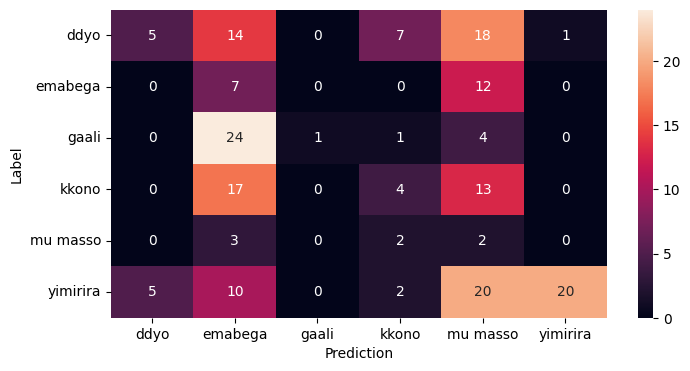

In [223]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [224]:
convert_bytes(get_file_size("model3.tflite"), "MB")

File size: 6.204 Megabytes


## Quntized model

In [225]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model3.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantize the TensorFlow Lite model
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmphomucos6/assets


INFO:tensorflow:Assets written to: /tmp/tmphomucos6/assets
2024-02-27 09:30:15.618331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:30:15.618364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:30:15.618565: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmphomucos6
2024-02-27 09:30:15.620258: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:30:15.620273: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmphomucos6
2024-02-27 09:30:15.625743: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:30:15.685860: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmphomucos6
2024-02-27 09:30:15.703380: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn8x82r1j/assets


INFO:tensorflow:Assets written to: /tmp/tmpn8x82r1j/assets
2024-02-27 09:30:18.783622: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-27 09:30:18.783665: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-27 09:30:18.783879: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpn8x82r1j
2024-02-27 09:30:18.785397: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-27 09:30:18.785410: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpn8x82r1j
2024-02-27 09:30:18.789165: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-27 09:30:18.843022: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpn8x82r1j
2024-02-27 09:30:18.855701: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

In [226]:
convert_bytes(get_file_size("quantized_model.tflite"), "KB")

File size: 1595.414 Kilobytes


In [227]:
# Evaluate the model on the test dataset
correct = 0
total = 0
for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    correct += bool(predicted_label == label)  # Convert to boolean
    total += 1

accuracy = correct / total
print(f'Accuracy: {accuracy}')


Accuracy: 0.203125


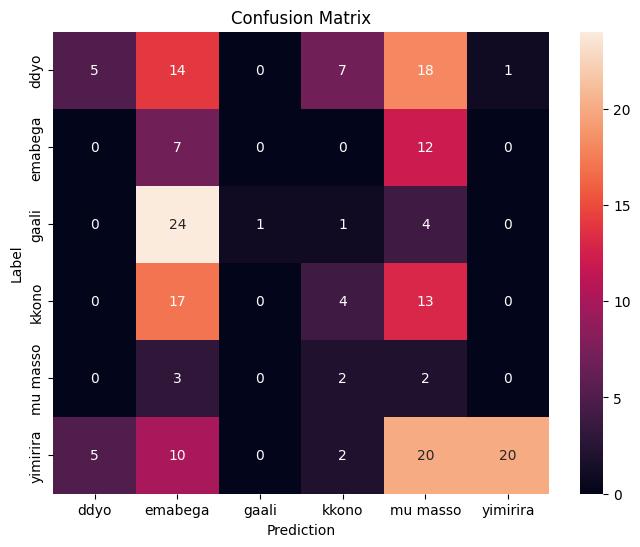

In [228]:
# Evaluate the model on the test dataset
y_true = []
y_pred = []

for spectrogram, label in test_spectrogram_ds:
    interpreter.set_tensor(input_details[0]['index'], spectrogram)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output)
    y_true.append(label)
    y_pred.append(predicted_label)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [229]:
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy is {int(accuracy*100)}%')

Accuracy is 20%
